### Importing Necessary libraries

In [1]:
# !pip install wget
# !pip install snapml
# !pip install scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import mean_squared_error

import time 
import warnings
import gc, sys
warnings.filterwarnings('ignore')

### Importing the dataset

In [3]:
import opendatasets as od

In [4]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/yellow_tripdata_2019-06.csv'
od.download(url)

Using downloaded and verified file: .\yellow_tripdata_2019-06.csv


In [5]:
raw_data = pd.read_csv('yellow_tripdata_2019-06.csv')

print("There are " + str(len(raw_data)) + " observations in the dataset.")
print("There are " + str(len(raw_data.columns)) + " variables in the dataset.")


There are 3936004 observations in the dataset.
There are 18 variables in the dataset.


In [6]:
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1,2019-06-01 00:55:13,2019-06-01 00:56:17,1.0,0.0,1.0,N,145.0,145.0,2.0,3.0,0.5,0.5,0.00,0.0,0.3,4.30,0.0
1,1,2019-06-01 00:06:31,2019-06-01 00:06:52,1.0,0.0,1.0,N,262.0,263.0,2.0,2.5,3.0,0.5,0.00,0.0,0.3,6.30,2.5
2,1,2019-06-01 00:17:05,2019-06-01 00:36:38,1.0,4.4,1.0,N,74.0,7.0,2.0,17.5,0.5,0.5,0.00,0.0,0.3,18.80,0.0
3,1,2019-06-01 00:59:02,2019-06-01 00:59:12,0.0,0.8,1.0,N,145.0,145.0,2.0,2.5,1.0,0.5,0.00,0.0,0.3,4.30,0.0
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.7,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,15.95,2.5


### Data Cleaning

In [7]:
# Removing all records where tip is 0
raw_data = raw_data[raw_data['tip_amount'] > 0]

# Removing outliers where tips are larger than the actual fare
raw_data = raw_data[raw_data['tip_amount'] <= raw_data['fare_amount']]

# Removing trips with large fare cosr
raw_data = raw_data[((raw_data['fare_amount'] >= 2) & (raw_data['fare_amount'] < 200))]

# Dropping unnecessary column total_amount
clean_data = raw_data.drop(['total_amount'], axis=1)

# Deleting raw data from memory
del raw_data
gc.collect()

# Stats about the data
print("There are " + str(len(clean_data)) + " observations in the dataset.")
print("There are " + str(len(clean_data.columns)) + " variables in the dataset.")

There are 2712719 observations in the dataset.
There are 17 variables in the dataset.


### Data Visualisation

In [8]:
clean_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge
4,1,2019-06-01 00:03:25,2019-06-01 00:15:42,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5
5,1,2019-06-01 00:28:31,2019-06-01 00:39:23,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5
7,1,2019-06-01 00:54:49,2019-06-01 01:02:57,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5
9,1,2019-06-01 00:29:12,2019-06-01 01:03:13,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5
10,2,2019-06-01 00:01:48,2019-06-01 00:16:06,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5


In [9]:
print("Minimum amount value is ", np.min(clean_data.tip_amount.values))
print("Maximum amount value is ", np.max(clean_data.tip_amount.values))
print("90% of the trips have a tip amount less or equal than ", np.percentile(clean_data.tip_amount.values, 90))

Minimum amount value is  0.01
Maximum amount value is  130.0
90% of the trips have a tip amount less or equal than  5.95


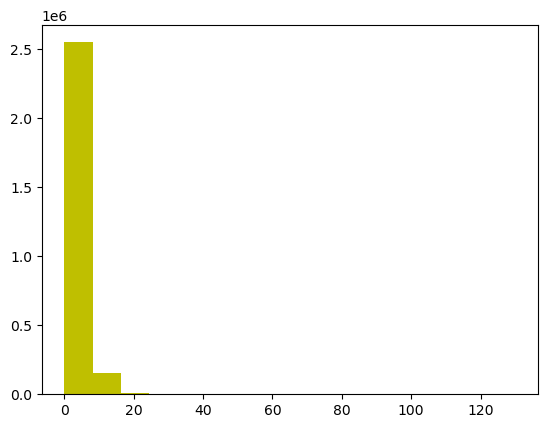

In [10]:
plt.hist(clean_data.tip_amount.values, 16, histtype='bar', facecolor='y')
plt.show()

### Data Preprocessing

In [11]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712719 entries, 4 to 3936000
Data columns (total 17 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           float64
 8   DOLocationID           float64
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  congestion_surcharge   float64
dtypes: float64(13), int64(1), object(3)
memory usage: 372.5+ MB


In [12]:
# Converting datetime values from object to datetime
clean_data['tpep_pickup_datetime'] = pd.to_datetime(clean_data['tpep_pickup_datetime'])
clean_data['tpep_dropoff_datetime'] = pd.to_datetime(clean_data['tpep_dropoff_datetime'])

In [15]:
# Extracting data from datetime columns

# Pickup and Dropoff hours
clean_data['pickup_hour'] = clean_data['tpep_pickup_datetime'].dt.hour
clean_data['dropoff_hour'] = clean_data['tpep_dropoff_datetime'].dt.hour

# Pickup and Drofoff days (day of the week 0(MONDAY) -> 6(SUNDAY))
clean_data['pickup_day'] = clean_data['tpep_pickup_datetime'].dt.weekday
clean_data['dropoff_day'] = clean_data['tpep_dropoff_datetime'].dt.weekday

# Trip time
clean_data['trip_time'] = (clean_data['tpep_dropoff_datetime'] - clean_data['tpep_pickup_datetime']).dt.total_seconds()

In [16]:
# Removing datetime columns as we don't need it anymore
clean_data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

In [17]:
clean_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,congestion_surcharge,pickup_hour,dropoff_hour,pickup_day,dropoff_day,trip_time
4,1,1.0,1.70,1.0,N,113.0,148.0,1.0,9.5,3.0,0.5,2.65,0.0,0.3,2.5,0,0,5,5,737.0
5,1,2.0,1.60,1.0,N,79.0,125.0,1.0,9.5,3.0,0.5,1.00,0.0,0.3,2.5,0,0,5,5,652.0
7,1,2.0,1.20,1.0,N,79.0,249.0,1.0,7.5,3.0,0.5,1.00,0.0,0.3,2.5,0,1,5,5,488.0
9,1,1.0,8.60,1.0,N,186.0,243.0,1.0,31.5,3.0,0.5,7.05,0.0,0.3,2.5,0,1,5,5,2041.0
10,2,1.0,1.74,1.0,N,107.0,148.0,1.0,11.0,0.5,0.5,2.96,0.0,0.3,2.5,0,0,5,5,858.0


### Label Encoding the categorized columns

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [19]:
# From the dataset, we have  categorical columns such as:
# 'VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'pickup_hour', 'dropoff_hour', 'pickup_day', 'dropoff_day'

cat_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'pickup_hour', 'dropoff_hour', 'pickup_day', 'dropoff_day']
for column in cat_cols:
    clean_data[column] = le.fit_transform(clean_data[column])

In [20]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2712719 entries, 4 to 3936000
Data columns (total 20 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   passenger_count        float64
 2   trip_distance          float64
 3   RatecodeID             int64  
 4   store_and_fwd_flag     int32  
 5   PULocationID           int64  
 6   DOLocationID           int64  
 7   payment_type           int64  
 8   fare_amount            float64
 9   extra                  float64
 10  mta_tax                float64
 11  tip_amount             float64
 12  tolls_amount           float64
 13  improvement_surcharge  float64
 14  congestion_surcharge   float64
 15  pickup_hour            int64  
 16  dropoff_hour           int64  
 17  pickup_day             int64  
 18  dropoff_day            int64  
 19  trip_time              float64
dtypes: float64(10), int32(1), int64(9)
memory usage: 424.3 MB


In [21]:
# Seperating dependant and independant variables
y = clean_data[['tip_amount']].values.astype('float32')

# drop the target variable from the feature matrix
X = clean_data.drop(['tip_amount'], axis=1).values

# normalize the feature matrix
X = normalize(X, axis=1, norm='l1', copy=False)

In [22]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (2712719, 19)
y shape: (2712719, 1)


### Train/Test Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1898903, 19) (813816, 19) (1898903, 1) (813816, 1)


### Decision Tree Regressor with Scikit-Learn

In [28]:
from sklearn.tree import DecisionTreeRegressor

# Initializing the model
sklearn_dt = DecisionTreeRegressor(max_depth=8, random_state=42)

# Fitting the model
t0 = time.time()
sklearn_dt.fit(X_train, y_train)
sklearn_time = time.time() - t0
print("[Scikit-Learn] Training time (s):  {0:.5f}".format(sklearn_time))

[Scikit-Learn] Training time (s):  33.24200


### Decision Tree Regressor with Snap ML

In [29]:
from snapml import DecisionTreeRegressor

# Initializing the model
snapml_dt = DecisionTreeRegressor(max_depth=8, random_state=42, n_jobs=4)

# Fitting the model
t0 = time.time()
snapml_dt.fit(X_train, y_train)
snapml_time = time.time() - t0
print("[Snap ML] Training time (s):  {0:.5f}".format(snapml_time))

[Snap ML] Training time (s):  1.53083


### Model(s) Evaluation

In [30]:
training_speedup = sklearn_time/snapml_time
print('[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : {0:.2f}x '.format(training_speedup))

[Decision Tree Regressor] Snap ML vs. Scikit-Learn speedup : 21.72x 


In [31]:
# Scikit-Learn Model Evaluation
sklearn_pred = sklearn_dt.predict(X_test)
sklearn_mse = mean_squared_error(y_test, sklearn_pred)
print('[Scikit-Learn] MSE score : {0:.3f}'.format(sklearn_mse))

# Snap ML Model Evaluation
snapml_pred = snapml_dt.predict(X_test)
snapml_mse = mean_squared_error(y_test, snapml_pred)
print('[Snap ML] MSE score : {0:.3f}'.format(snapml_mse))

[Scikit-Learn] MSE score : 1.836
[Snap ML] MSE score : 1.706


##### Changing max_depth PARAM to 12 to observe changes in the snapML model

In [32]:
tree = DecisionTreeRegressor(max_depth=12, random_state=42, n_jobs=4)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=12, n_jobs=4, random_state=42)

In [33]:
tree_pred = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
print('[Snap ML: max_depth = 12] MSE score : {0:.3f}'.format(tree_mse))

[Snap ML: max_depth = 12] MSE score : 1.793


##### There is an increase in the MSE with increase in the depth of the decision tree